# Age Estimation

In [ ]:
import os
import numpy as np
import torch
from helperT import *

# Loading Data

PyTorch Datasets are objects that have a single job: to return a single datapoint on request. The exact form of the datapoint varies between tasks: it could be a single image, a slice of a time series, a tabular record or something else entirely. These are then passed on to a Dataloader which handles batching of datapoints and parallelism. 

We've written the dataloader function and transform function for you. `get_dataloaders()` will return three object: train_loader, val loader and test_loader.

```
Arguments:
    None
Return:
    train_loader      -- tensor,(y, x), [(32),(32, 2048)] 
    val_loader        -- tensor,(y, x), [(32),(32, 2048)] 
    test_loader       -- tensor,(y, x), [(32),(32, 2048)] 
```

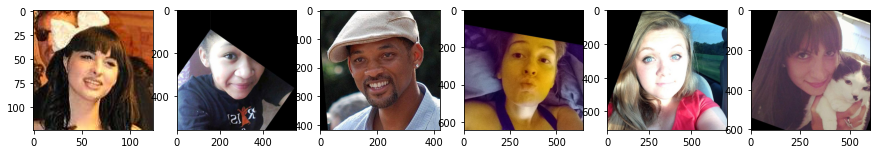

In [4]:
train_loader, val_loader, test_loader = get_dataloaders("DATASET/")
show_data('DATASET/')

# Define Model
In this part, we will define our linear regression model here. First let's declare a class called `LinearClassifier` that inherit from `torch.nn.moudle`. Then you have to define the initialization in `__init__`, and define forward propogation in `forward` function.
Hint: You can use torch.nn.Linear.
```
Arguments:
    __init__        --(input_size, output_size)
Return:
    out      -- tensor, network calculation results 
```


In [ ]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearClassifier, self).__init__()
        #############################################
        # TODO: YOUR CODE HERE
        ############################################# 
        self.linear = torch.nn.Linear(inputSize, np.int16(inputSize * 5 / 8))
        self.linear2 = torch.nn.Linear(np.int16(inputSize * 5 / 8), outputSize)

    def forward(self, x):
        #############################################
        # TODO: YOUR CODE HERE
        ############################################# 
        x = torch.nn.functional.relu(self.linear(x))
        out = self.linear2(x)
        return out

# softmax + CELoss

=> [epoch 0001] mae: 10.28867 loss: 4.091
=> [epoch 0002] mae: 6.75400 loss: 3.692
=> [epoch 0003] mae: 5.81400 loss: 3.494
=> [epoch 0004] mae: 5.51133 loss: 3.382
=> [epoch 0005] mae: 5.45933 loss: 3.313
=> [epoch 0006] mae: 5.35067 loss: 3.267
=> [epoch 0007] mae: 5.33933 loss: 3.233
=> [epoch 0008] mae: 5.31533 loss: 3.209
=> [epoch 0009] mae: 5.28000 loss: 3.194
=> [epoch 0010] mae: 5.23333 loss: 3.185
=> [epoch 0011] mae: 5.20133 loss: 3.180
=> [epoch 0012] mae: 5.19333 loss: 3.179
=> [epoch 0013] mae: 5.16133 loss: 3.179
=> [epoch 0014] mae: 5.09533 loss: 3.180
=> [epoch 0015] mae: 5.06867 loss: 3.182
=> [epoch 0016] mae: 5.05400 loss: 3.185
=> [epoch 0017] mae: 5.07067 loss: 3.188
=> [epoch 0018] mae: 5.07867 loss: 3.191
=> [epoch 0019] mae: 5.08733 loss: 3.194
=> [epoch 0020] mae: 5.08267 loss: 3.197
=> [epoch 0021] mae: 5.08000 loss: 3.200
=> [epoch 0022] mae: 5.07667 loss: 3.203
=> [epoch 0023] mae: 5.07000 loss: 3.206
=> [epoch 0024] mae: 5.06267 loss: 3.209
=> [epoch 0025]

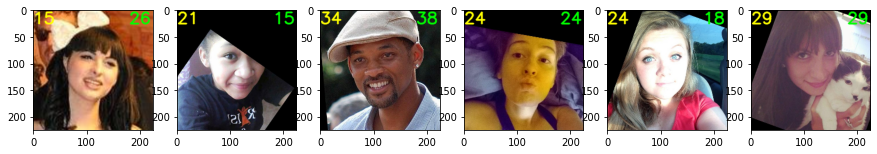

In [6]:
def train_softmax_cel():
    # Define model
    model = LinearClassifier(2048, 101)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define SGD optimizer to update our weights and bias
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Define criterion to calculate loss
    criterion = torch.nn.CrossEntropyLoss()

    for e in range(EPOCH):
        # Training model
        model.train()

        for i, (y, x) in enumerate(train_loader):
            #############################################
            # TODO: YOUR CODE HERE
            #############################################
            x, y = x.cuda().float(), y.cuda().long()
            # calculate the gradient and update the model
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

       # Validating model
        model.eval()
        gt = []
        preds = []

        for i, (y, x) in enumerate(val_loader):
            #############################################
            # TODO: YOUR CODE HERE
            ############################################# 
            # Calculate the validation outputs and error 
            x, y = x.cuda().float(), y.cuda().long()
            outputs = model(x)
            loss = criterion(outputs, y)
            _, predicted = torch.max(outputs, 1)

            # Save the predictions for validation sets and ground truth
            preds.append(predicted.cpu().detach().numpy())
            gt.append(y.cpu().numpy())

        # Change prediction and ground truth to numpy
        preds = np.concatenate(preds, axis=0)
        gt = np.concatenate(gt, axis=0)

        # Calculate difference and mae
        diff = preds - gt
        mae = np.abs(diff).mean()

        #############################################
        # TODO: YOUR CODE HERE
        ############################################# 
        # save the model according to the validation error
        checkpoint = {'net': model.state_dict()}
        torch.save(checkpoint, '/content/drive/My Drive/CIS 581/Project 8/net_checkpoint.pt')
        print("=> [epoch", format(e + 1, "04") + "] mae:", format(mae, ".5f"), "loss:", format(loss.item(), ".3f"))
        
    print("=> training finished")
    return model, preds, gt

model_softmax_cel, preds, gt = train_softmax_cel()
show_results(preds, gt)

# Test and Generate results file

In [7]:
prediction = test_cel(model_softmax_cel, test_loader, "softmax_cel.txt")
print("Test results has saved to softmax_cel.txt")
print(prediction[:10])

Test results has saved to softmax_cel.txt
[25.87080943 62.80737264 49.99299681 21.1050622  31.56246921 35.15018389
 49.06823984 41.32419922 21.68329736 58.55367824]
